In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm

import ot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Quasi-random sequences
from sobol_seq import i4_sobol_generate

### Kernel SoS OT functions
from optim import interior_point
from utils import make_kernels, transport_cost, transport_1D, potential_1D

## Sample data

In [2]:
nfill = 100
nsamples = 100

### Sample from mu and nu

In [3]:
n = 2000

mu1 = [0.7, 0.3]
mu2 = [0.2, 0.5, 0.75]


t1 = [0.4, 0.6]
t2 = [0.2, 0.2, 0.6]

x = np.linspace(0, 1, n)
    
r_tmp = []    
for mode in mu1:
    r_tmp.append(norm.pdf(x,mode, 0.09))
        
c_tmp = []    
for mode in mu2:
    c_tmp.append(norm.pdf(x,mode, 0.075))
        
mu = np.dot(t1,r_tmp)
nu = np.dot(t2,c_tmp)



In [4]:
np.random.seed(123)

u1 = np.random.rand(nsamples)
u2 = np.random.rand(nsamples)

X = np.zeros(nsamples)
Y = np.zeros(nsamples)

for i in range(nsamples):
    if u1[i] < t1[0]:
        X[i] = np.random.randn() * .1 + mu1[0]
    else:
        X[i] = np.random.randn() * .1 + mu1[1]
    if u2[i] < t2[0]:
        Y[i] = np.random.randn() * .075 + mu2[0]
    elif u2[i] < t2[1] + t2[0]:
        Y[i] = np.random.randn() * .075 + mu2[1]
    else:
        Y[i] = np.random.randn() * .075 + mu2[2]


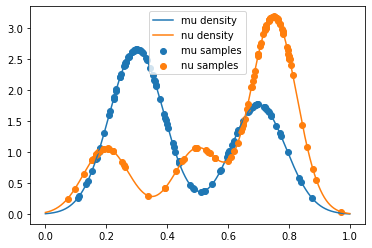

In [5]:
x = np.linspace(0, 1, n)

f, ax = plt.subplots()

ax.plot(x, mu, label = 'mu density')
ax.plot(x, nu, label = 'nu density')

ax.scatter(X, mu[(n * X).astype(int)], label = 'mu samples')
ax.scatter(Y, nu[np.minimum((n * Y).astype(int), n-1)], label = 'nu samples')


plt.legend()
plt.show()

## Sample filling points

In [6]:
### Sobol quasi-random samples to fill the space X x Y. 
sob = i4_sobol_generate(2 , nfill, skip = 3000)


## Add some points in the corners (optional)
sob = np.insert(sob, 0, np.array([1e-2, 1e-2]))
sob = np.insert(sob, 0, np.array([1-1e-2, 1-1e-2]))
sob = np.insert(sob, 0, np.array([1e-2, 1-1e-2]))
sob = np.insert(sob, 0, np.array([1.-1e-2, 1e-2]))

sob = sob.reshape(-1, 2)[:-4 , :]


X_fill = sob[:, :1]
Y_fill = sob[:, 1:]    

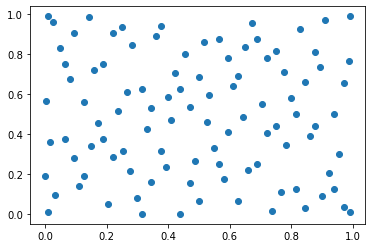

In [7]:
plt.scatter(X_fill, Y_fill)

## Compute the model

### Build kernel matrices

In [8]:
kernel = 'gaussian'
l = .1
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(X[:, None], Y[:, None], X_fill, Y_fill, l=l, kernel = kernel)

### Run optimization

In [9]:
## Regularization parameters

lbda_1 = 1 / nfill
lbda_2 =  1 / nsamples


## Optimization problem parameters

eps_start = nfill
eps_end = 1e-8

tau = 1e-8

niter = 1000




In [10]:
G, eps = interior_point(M, Phi, Kx1, Kx2, Kx3, Ky1, Ky2, Ky3,lbda_1=lbda_1, lbda_2=lbda_2,
                      eps_start=eps_start, eps_end=eps_end, eps_div = 2,
                      tau=tau, niter=niter,
                      verbose=True, report_interval=100)

kernel_sos_ot = transport_cost(G, Kx2, Kx3, Ky2, Ky3, lbda_2, product_sampling=False)

iter 1:	transport: -6.81e-01	decr: 4.83e+01	eps: 1.00e+02
iter 101:	transport: -9.19e-01	decr: 2.23e-03	eps: 9.77e-02
iter 201:	transport: 1.66e-02	decr: 4.29e-03	eps: 2.98e-06
iter 252:	transport: 1.66e-02	decr: 4.93e-09	eps: 5.82e-09
Precision 1.00e-08 reached in 1.27e-01 seconds


In [11]:
### Compute OT from samples
x = np.linspace(0., 1., n)

M_ot = ((x[:, None] - x)**2) / 2
P, log = ot.emd(mu / mu.sum(), nu / nu.sum(), M_ot, log = True)
sampled_ot = (P * M_ot).sum()

In [12]:
print(f"Plugin estimator (n={n}): {sampled_ot:.3e}\nKernel SoS estimator (n={nsamples}, l={nfill}): {kernel_sos_ot:.3e}")

Plugin estimator (n=2000): 1.377e-02
Kernel SoS estimator (n=100, l=100): 1.658e-02


## Visualize maps and potentials


<Figure size 432x288 with 0 Axes>

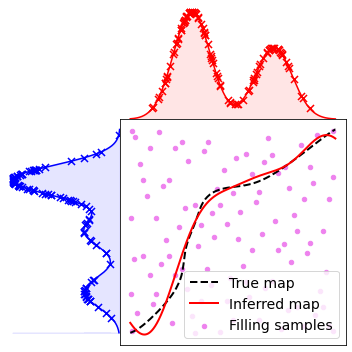

In [13]:
import matplotlib.gridspec as gridspec

plt.clf()

fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

xp, yp = np.where(P > 0)

na, nb = P.shape

xa = np.arange(na)
xb = np.arange(nb)

Txa = np.argmax(P, 1)


ax1 = plt.subplot(gs[0, 1:])
ax1.plot(xa, mu,  'r', label='Source distribution')
ax1.fill_between(xa, mu, color = 'red', alpha=.1)
plt.ylim(ymin=0)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
ax1.axis('off')

ax2 = plt.subplot(gs[1:, 0])
ax2.plot((nu), xb, 'b', label='Target distribution')
ax2.fill_between((nu)[:], xb[:], color = 'blue', interpolate=True, alpha = .1)
ax2.set_xlim(xmin=0)
ax2.invert_xaxis()

ax2.axis('off')


ax3 = plt.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax3.plot(xa, Txa , linewidth = 2, color = 'black', ls ='--', label='True map')

x = np.linspace(0, 1, len(xa)) 
TX = transport_1D(x, G, X, X_fill, lbda_2, kernel=kernel, l=l) 

ax3.plot(xa, TX * na, color = 'r', lw =2, label = 'Inferred map')

ax1.scatter(X * na, mu[(n * X).astype(int)], label = 'mu samples', marker = 'x', color = 'r', s=50)
ax2.scatter( nu[np.minimum((n * Y).astype(int), n-1)], Y * na, 
            label = 'nu samples', marker = 'x', color = 'b', s = 50)


ax3.scatter(sob[:, 0] * na, sob[:, 1] * na, color = 'violet', s =20, label = 'Filling samples')

    
plt.tight_layout()
plt.legend(fontsize = 14)

plt.show()

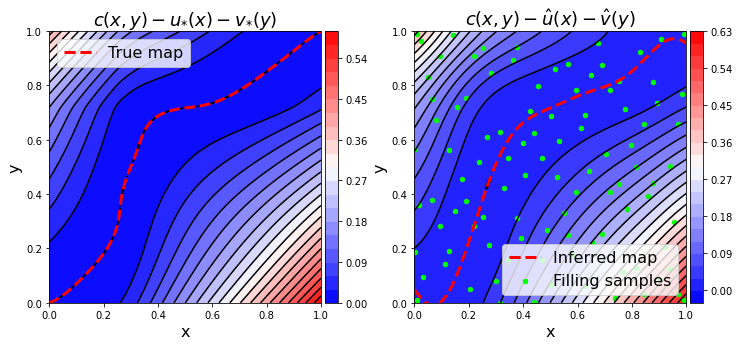

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = np.linspace(0., 1., n)
y = np.linspace(0., 1., n)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = ax

### True constraint function

#### Compute true function
a = log['u']
b = log['v']
Z = M_ot - a - b[:, None] 


#### Plot
levels = 20
CS = ax1.contour(x, y, Z, levels= levels, colors= 'black')
CF = ax1.contourf(x, y, Z, levels = levels, cmap = 'bwr')
ax1.plot(x, Txa/na, color = 'r', ls = '--', lw = 3, label = 'True map')

## nice colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(CF, cax=cax)

ax1.set_aspect('equal')
ax1.set_xlabel('x', fontsize = 16)
ax1.set_ylabel('y', fontsize = 16)
ax1.set_title(r'$c(x, y) - u_{*}(x) - v_{*}(y)$', fontsize = 18)
ax1.legend(fontsize = 16)


### Inferred constraint function

#### Compute model
M_ot = ((x[:, None] - y)**2) / 2
u = potential_1D(x[:, None], G, X, X_fill, lbda_2, l, kernel)
v = potential_1D(x[:, None], G, Y, Y_fill, lbda_2, l, kernel)
Z = M_ot - u - v[:, None]

#### Plot
CS = ax2.contour(x, y, Z, levels= levels, colors= 'black')
CF = ax2.contourf(x, y, Z, levels = levels, cmap = 'bwr')

ax2.set_aspect('equal')
ax2.plot(xa/ na, TX, color = 'r', lw =3, ls = '--', label = 'Inferred map')
ax2.set_ylim(ymin = 0, ymax=1)
ax2.scatter(X_fill, Y_fill, color = 'lime', s=20, label='Filling samples')

#### nice colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(CF, cax=cax)

ax2.set_xlabel('x', fontsize = 16)
ax2.set_ylabel('y', fontsize = 16)
ax2.set_title(r'$c(x,y) - \hat{u}(x) - \hat{v}(y)$', fontsize = 18)
ax2.legend(fontsize = 16)


plt.show()

